# Belief to eye position

there are evidence (refer to ruiyi) that eye position suggest belief.
we would like to have IRC behavioral infered belief to support this claim.
here, we fit the belief to eye position and see.

## data preparetion

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# imports
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])

In [3]:
sys.path.append(os.path.abspath(workdir))
sys.path.append(os.path.abspath(workdir/'test'))
# os.chdir(workdir/'test/neural')
os.chdir(workdir)

In [4]:

from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
import torch
from sklearn.cross_decomposition import CCA
from numpy import pi
from matplotlib import pyplot as plt
from firefly_utils.data_handler import data_handler
from firefly_utils.spike_times_class import spike_counts
from firefly_utils.behav_class import *
from firefly_utils.lfp_class import lfp_class
from copy import deepcopy
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.io import loadmat
import pickle
import pandas as pd
from numpy.lib.npyio import save
from cmaes import CMA
import copy
import matplotlib.pyplot as plt
import warnings
import heapq
from torch.distributions.multivariate_normal import MultivariateNormal
import time
from stable_baselines3 import TD3
from InverseFuncs import *
from monkey_functions import *
from firefly_task import ffacc_real
from env_config import Config
from notification import notify
from pathlib import Path
from sklearn import linear_model
from plot_ult import *
from sklearn.metrics import mean_squared_error, r2_score
import random
import scipy.interpolate as interpolate
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV

### Load neural data (.mat file) and behaviral data (from IRC)
the neural data file also has some behaivral data, such as current velocity.
we can use this as a sanity check to making sure things are right.

In [5]:
# load neural data

# this is a example session with good recording, more neurons
dat = loadmat(resdir/'neuraltest/m53s31.mat')
# dat = loadmat(resdir/'neural/m53s36.mat') # this is a pert example


behav_stat_key = 'behv_stats'
spike_key = 'units'
behav_dat_key = 'trials_behv'
lfp_key = 'lfps'

pre_trial_dur = 0.5
post_trial_dur = 0.5
exp_data = data_handler(dat, behav_dat_key, spike_key, lfp_key,
                        behav_stat_key, pre_trial_dur=pre_trial_dur,             extract_fly_and_monkey_xy=True,
                        post_trial_dur=post_trial_dur, extract_cartesian_eye_and_firefly=True,
                        lfp_beta=None, lfp_alpha=None, extract_lfp_phase=True)
# list(exp_data.behav.continuous.__dict__.keys())
exp_data.set_filters('all', True)
ts = exp_data.rebin_time_stamps(0.1)
t_targ = dict_to_vec(exp_data.behav.events.t_targ)
t_start = t_targ
t_stop = dict_to_vec(exp_data.behav.events.t_stop)
var_names = 'rad_vel', 'ang_vel', 'x_monk', 'y_monk', 'eye_hori', 'eye_vert', 'x_fly_screen', 'z_fly_screen', 'x_eye_screen', 'z_eye_screen', "x_fly_rel", "y_fly_rel", "ang_vel"
y, X, trial_idx = exp_data.concatenate_inputs(
    *var_names, t_start=t_start, t_stop=t_stop, time_stamps=ts)

trials = np.unique(trial_idx)
yes = 0
total = 0
for itrial in range(len(trials)):
    if len(X['x_fly_rel'][trial_idx == trials[itrial]]) < 1:
        continue
    d = (X['x_fly_rel'][trial_idx == trials[itrial]][-1]**2 +
         X['y_fly_rel'][trial_idx == trials[itrial]][-1]**2)**0.5
    if d < 65:
        yes += 1
    total += 1
print(f'number of trial: {len(trials)}, \nsession success rate is ', yes/total)


brainarea = dat['units']['brain_area']

unable to extract pairs, different blocks number
no eyetracking...
no normalized t_ptb (t_ptbn)
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
number of trial: 700, 
session success rate is  0.5642857142857143


In [6]:
# load behavioral data

with open(resdir/'neuraltest/res/m53s31_0928newformatbelief', 'rb') as f:
    res = pickle.load(f)

y_ = res['y']
X_mat = X
X = {k: res[k] for k in ['rad_vel', 'ang_vel', 'x_monk', 'y_monk']}
trial_idx = res['trial_idx']
beliefs = res['belief']
covs = res['covs']
mask = res['mask']
s = np.vstack([v for v in X.values()])
s = s.T

In [7]:
# use b-spline to process neural data

kernel_len = 7  # should be about +- 325ms
knots = np.hstack(([-1.001]*3, np.linspace(-1.001, 1.001, 5), [1.001]*3))
tp = np.linspace(-1., 1., kernel_len)
bX = splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

# with initiate_plot(3, 2, 200) as f:
#     ax = f.add_subplot(111)
#     plt.plot(bX)
#     plt.title('B-spline kernel')
#     quickspine(ax)
#     plt.xticks([0, kernel_len-1])
#     ax.set_xticklabels([-kernel_len*50, kernel_len*50])
#     plt.xlabel('time, ms')
#     plt.ylabel('coef')


with suppress():
    modelX = convolve_loop(y_.T, trial_idx, bX)  # ts, neurons
pos_xy = np.hstack((X['x_monk'].reshape(-1, 1),
                   X['y_monk'].reshape(-1, 1)))  # ts, xy
# remove bad data
non_nan = ~np.isnan(pos_xy.sum(axis=1))
modelX = modelX[non_nan]
pos_xy = pos_xy[non_nan]
belief_xy = beliefs[:, [0, 1]][non_nan]

In [8]:
# calculate relative beliefs and states

states_rel, belief_rel = [], []
for itrial in range(len(trials)):
    xr, yr = world2mk(X['x_monk'][trial_idx == trials[itrial]], X['y_monk'][trial_idx == trials[itrial]], X['ang_vel'][trial_idx ==
                      trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    states_rel.append(np.vstack([xr, yr]))

    xr, yr = world2mk(beliefs[trial_idx == trials[itrial]][:, 0], beliefs[trial_idx == trials[itrial]][:, 1], X['ang_vel']
                      [trial_idx == trials[itrial]], exp_data.behav.continuous.x_fly[trials[itrial]], exp_data.behav.continuous.y_fly[trials[itrial]])
    belief_rel.append(np.vstack([xr, yr]))

states_rel = np.hstack(states_rel).T
belief_rel = np.hstack(belief_rel).T

In [9]:
# calculate the relative cov (rotate ccw 180+heading from mid degree)

belief_heading = beliefs[:, 2][non_nan]
rotdegree = belief_heading+180
relativeposcov = []
for degree, thiscov in zip(rotdegree, covs):
    R = np.array([[np.cos(-degree/180*pi), -np.sin(-degree/180*pi)],
                 [np.sin(-degree/180*pi), np.cos(-degree/180*pi)]])
    relativeposcov.append(R.T@thiscov[:2, :2]@R)
relativeposcov = np.stack(relativeposcov)
relativeposcov.shape

(11331, 2, 2)

In [10]:
# uncertainty var and std from cov.

uncertainty_var = [c[:2, :2].flatten()[[0, 3]] for c in relativeposcov]
uncertainty_var = np.array(uncertainty_var)
uncertainty_std = np.power(uncertainty_var, 0.5)[:,]

In [11]:
# time

trialtime = []
fulltime = np.arange(0, 7, 0.1)
for itrial in range(len(trials)):
    thistime = len(X['x_monk'][trial_idx == trials[itrial]])
    trialtime.append(fulltime[:thistime])
trialtime = np.hstack(trialtime).T

trialtime = trialtime.reshape(-1, 1)

In [12]:
# cumulative distance traveled and angle turned

pathtraveled = []
for itrial in range(len(trials)):
    thisv = np.cumsum(X['rad_vel'][trial_idx == trials[itrial]])
    thisw = np.cumsum(X['ang_vel'][trial_idx == trials[itrial]])
    pathtraveled.append(np.stack([thisv, thisw]))
pathtraveled = np.hstack(pathtraveled).T

In [13]:
# eye
eyeh = X_mat['eye_hori'][mask[0]][mask[1]]
eyev = X_mat['eye_vert'][mask[0]][mask[1]]

In [14]:
def quantilenormalize(together, scale=100):
    return (together-np.quantile(together, 0.05, axis=0))/(np.quantile(together, 0.95, axis=0)-np.quantile(together, 0.05, axis=0))*scale

# Fitting belief to eye position


## overhead belief --> eye position angle


expect fit not that good because the data is biased.
better turn the agnles into the overhead view.

### fit the data

In [34]:
x = quantilenormalize(np.hstack([belief_rel, uncertainty_var,
                     uncertainty_std, trialtime, pathtraveled]))

y = (np.vstack([eyeh, eyev])).T

x.shape, y.shape

((11331, 9), (11331, 2))

In [35]:
# Create a parameter grid with alpha values
param_grid = {'alpha': [0.1, 1.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)

Best alpha value: 1.0


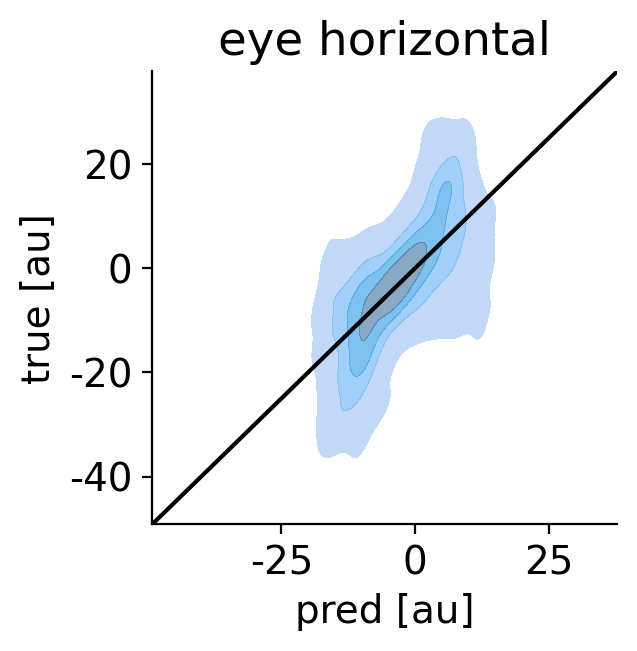

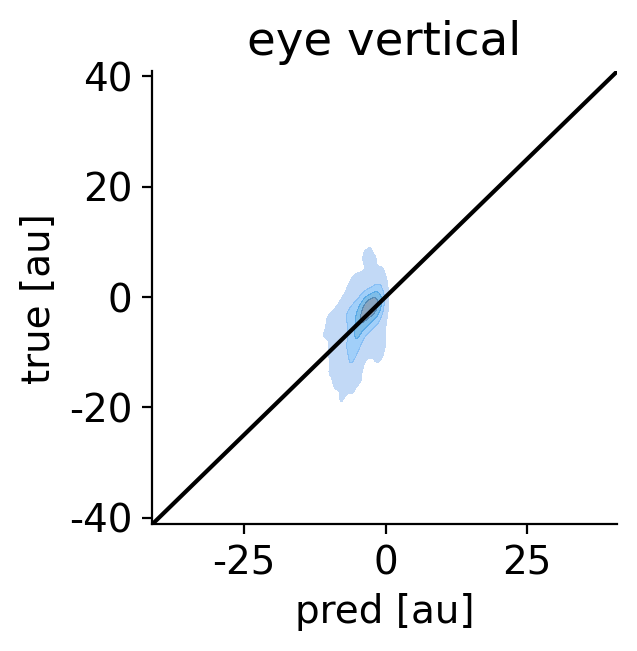

In [36]:
model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)

pred=model.predict(x)
plot_pred(pred[:,0],y[:,0], title='eye horizontal', unit='au',every=1)
plot_pred(pred[:,1],y[:,1], title='eye vertical', unit='au',every=1)

better use scatter plot to double check


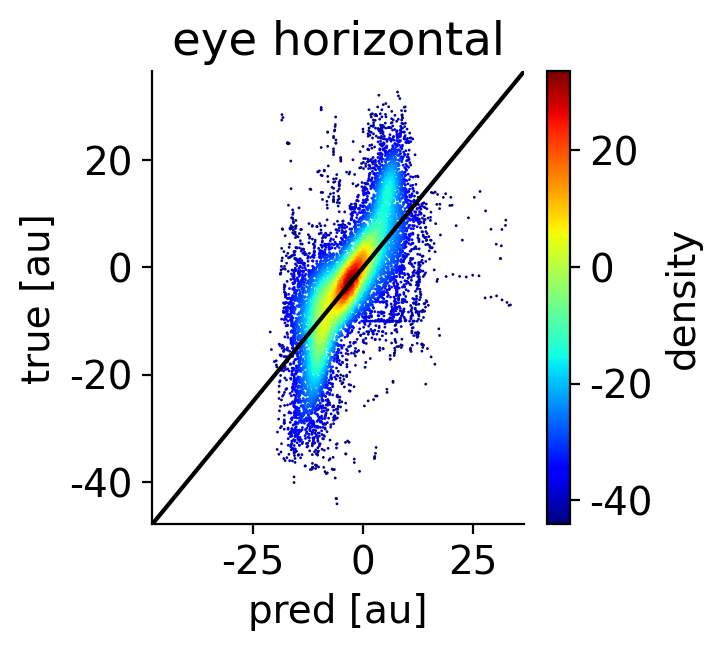

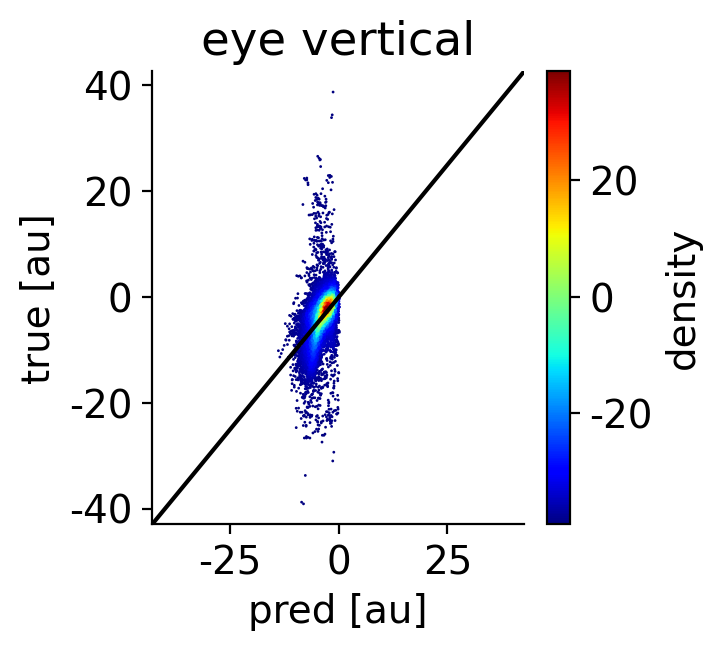

In [37]:

plot_pred_scatter(pred[:,0],y[:,0], title='eye horizontal', unit='au',every=1)
plot_pred_scatter(pred[:,1],y[:,1], title='eye vertical', unit='au',every=1)


### analyze the model coef. is unceratinty important in predicting eye pos?

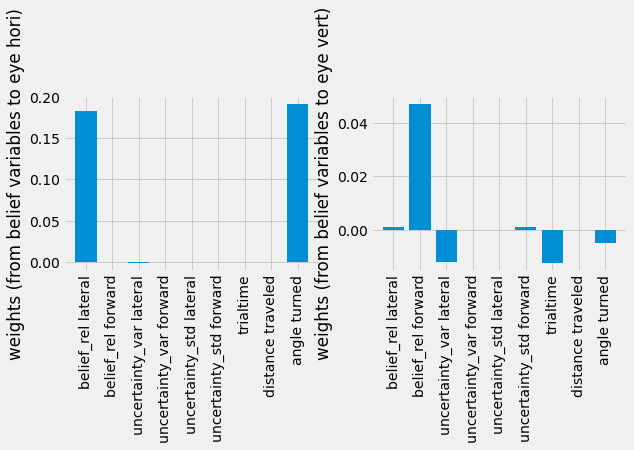

In [59]:
fig, axs = plt.subplots(1,2, figsize=(9,3))
plt.style.use('fivethirtyeight')

# the model weights from 9 dim belief to eye hori
ax=axs[0]
varnames=['belief_rel lateral','belief_rel forward', 'uncertainty_var lateral','uncertainty_var forward',
                     'uncertainty_std lateral','uncertainty_std forward', 'trialtime', 'distance traveled','angle turned']
ax.bar(np.arange(0,len(model.coef_[0])), model.coef_[0])
ax.set_xticks(np.arange(0,len(model.coef_[0])))
ax.set_xticklabels(varnames, rotation=90)
ax.set_ylabel('weights (from belief variables to eye hori)')
# plt.show()

# the model weights from 9 dim belief to eye vert
ax=axs[1]
varnames=['belief_rel lateral','belief_rel forward', 'uncertainty_var lateral','uncertainty_var forward',
                     'uncertainty_std lateral','uncertainty_std forward', 'trialtime', 'distance traveled','angle turned']
ax.bar(np.arange(0,len(model.coef_[1])), model.coef_[1])
plt.xticks(np.arange(0,len(model.coef_[1])))
plt.gca().set_xticklabels(varnames, rotation=90)
plt.ylabel('weights (from belief variables to eye vert)')

plt.tight_layout()
plt.show()


hard to explain.
however, we can have some hypothesis.
for example, when uncertainty is high, the monkey may not be able to keep tracking the target.
if this is true, then we will see a drop in correlation (belief mu vs eye position)

we know time mattes to the uncertainty. 
thus, as a start, we can check if late vs early part of the trial data, and see if the correlation changes.

### compare the belief mu --> eye pos correlation, of early vs late part of the trail

In [141]:
# select the first half of trial's index
earlyinds=[np.where(trial_idx==ith)[0][:len(np.where(trial_idx==ith)[0])//2] for ith in np.unique(trial_idx)]

lateinds=[np.where(trial_idx==ith)[0][len(np.where(trial_idx==ith)[0])//2:len(np.where(trial_idx==ith)[0])] for ith in np.unique(trial_idx)]


earlyinds=np.hstack(earlyinds)
lateinds=np.hstack(lateinds)

In [142]:
# fit the first and second half seperately. (belief mu --> eye hori and vert)
earlymodel = linear_model.Lasso(alpha=best_alpha)
# earlymodel.fit(belief_rel[earlyinds],y[earlyinds])
print('earlymodel r2', np.mean(cross_val_score(earlymodel,
      belief_rel[earlyinds], y[earlyinds], cv=3)))

latemodel = linear_model.Lasso(alpha=best_alpha)
# latemodel.fit(belief_rel[lateinds],y[lateinds])
print('latemodel r2', np.mean(cross_val_score(
    latemodel, belief_rel[lateinds], y[lateinds], cv=3)))

earlymodel r2 0.2924568774137383
latemodel r2 0.11385252558067681


In [144]:
earlypred = cross_val_predict(
    earlymodel, belief_rel[earlyinds], y[earlyinds], cv=3)
latepred = cross_val_predict(
    latemodel, belief_rel[lateinds], y[lateinds], cv=3)

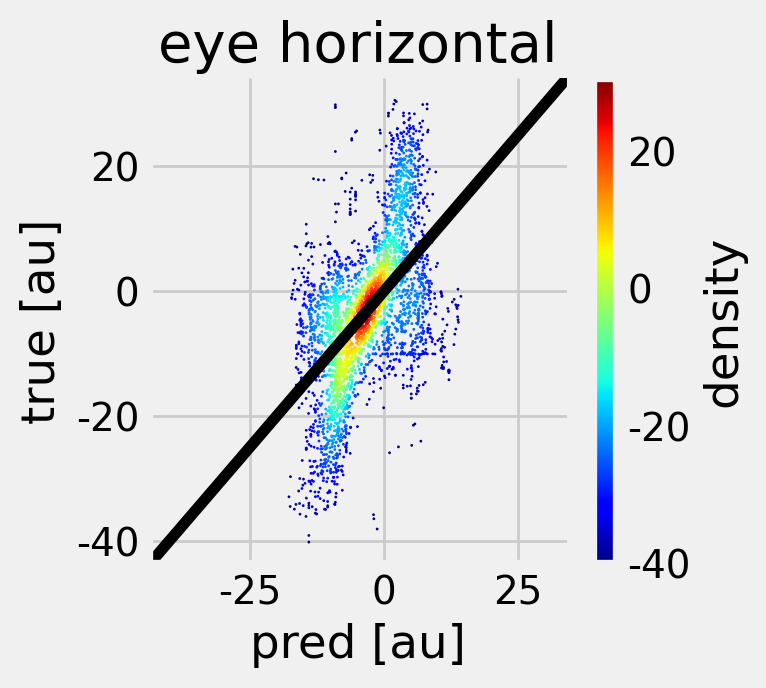

In [100]:
# early prediction
plot_pred_scatter(earlypred[:,0],y[earlyinds][:,0], title='eye horizontal', unit='au',every=1)
# plot_pred_scatter(earlypred[:,1],y[earlyinds][:,1], title='eye vertical', unit='au',every=1)


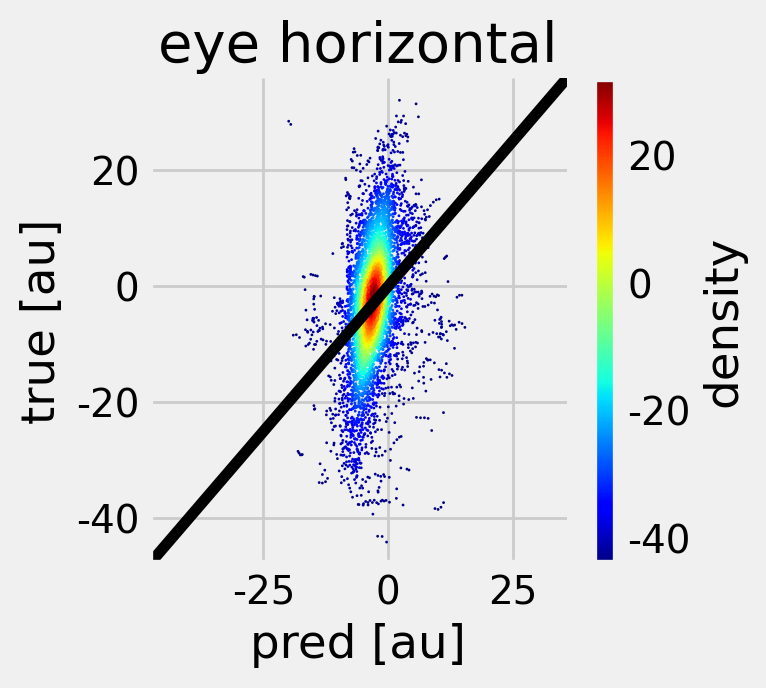

In [145]:
# late prediction
plot_pred_scatter(latepred[:,0],y[lateinds][:,0], title='eye horizontal', unit='au',every=1)
# plot_pred_scatter(latepred[:,1],y[lateinds][:,1], title='eye vertical', unit='au',every=1)


conclusion. 
indeed! the later half of the trial has weak correlation (belief mu-->eye pos.)

however, still somehing we did not explain. 
eg, there are some obvious outliers in the fitting.
what are they?
are they just saccades, or somethhing else?

one way to check this, is to visualize the eye path and belief path together.
we can then see the smooth pursuite, vs the potential noisy saccades.

### bin the trial time and fit

Text(0, 0.5, 'number of trials')

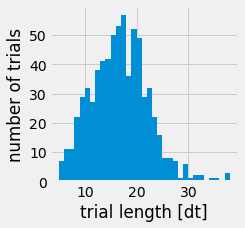

In [107]:
# get a sense of trial len distribution
lens=([len(np.where(trial_idx==ith)[0]) for ith in np.unique(trial_idx)])
_=plt.hist(lens, bins=33)
plt.xlabel('trial length [dt]')
plt.ylabel('number of trials')

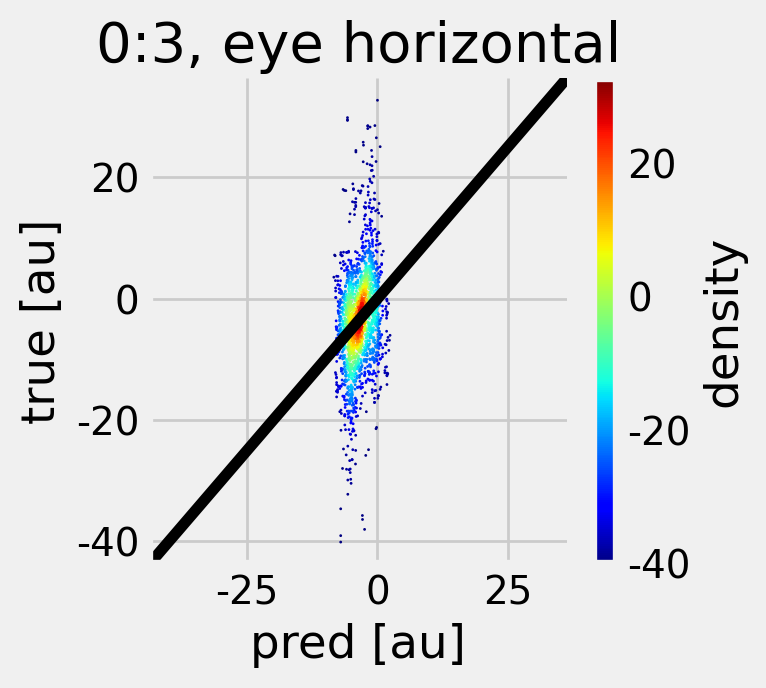

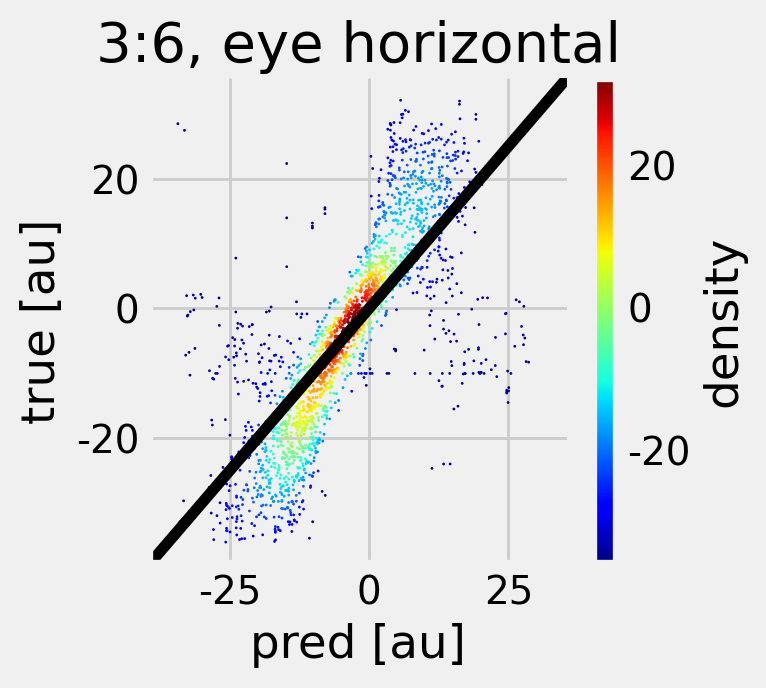

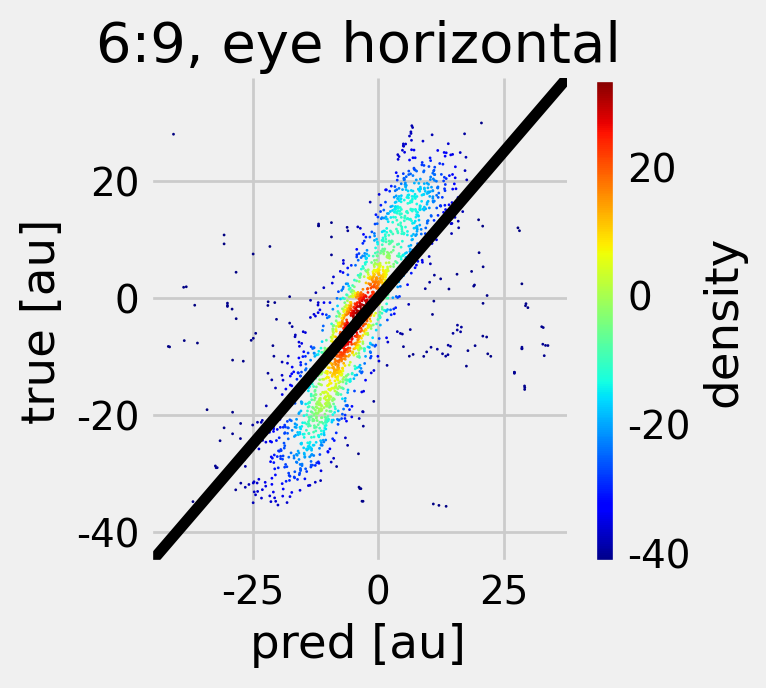

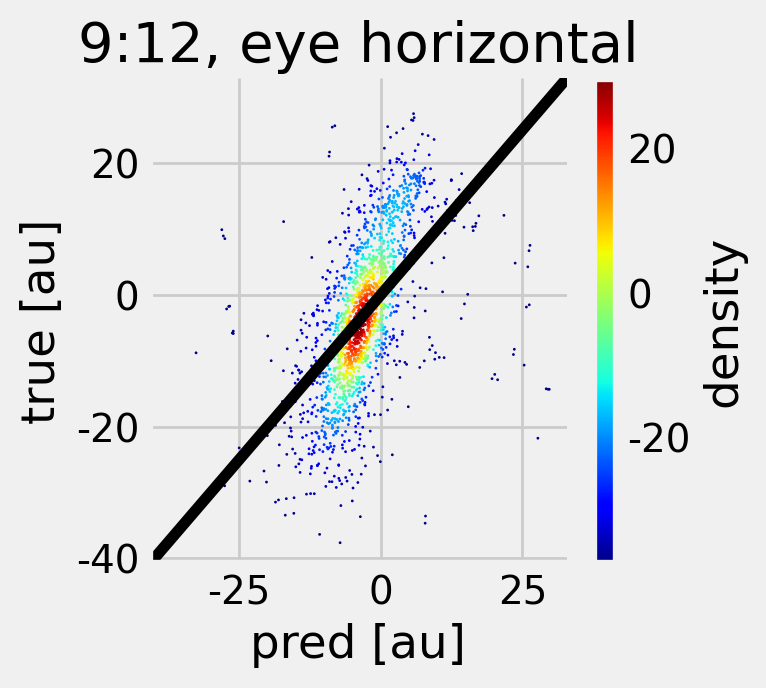

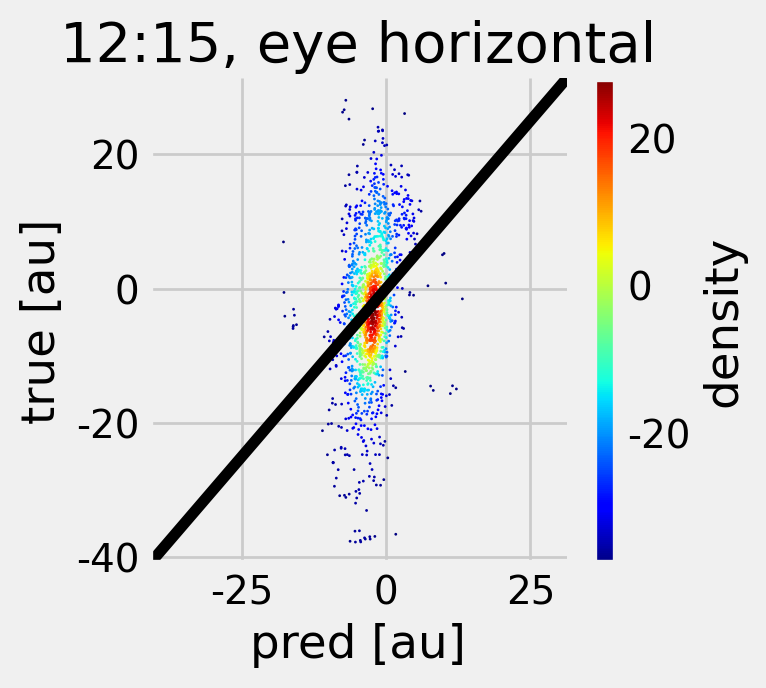

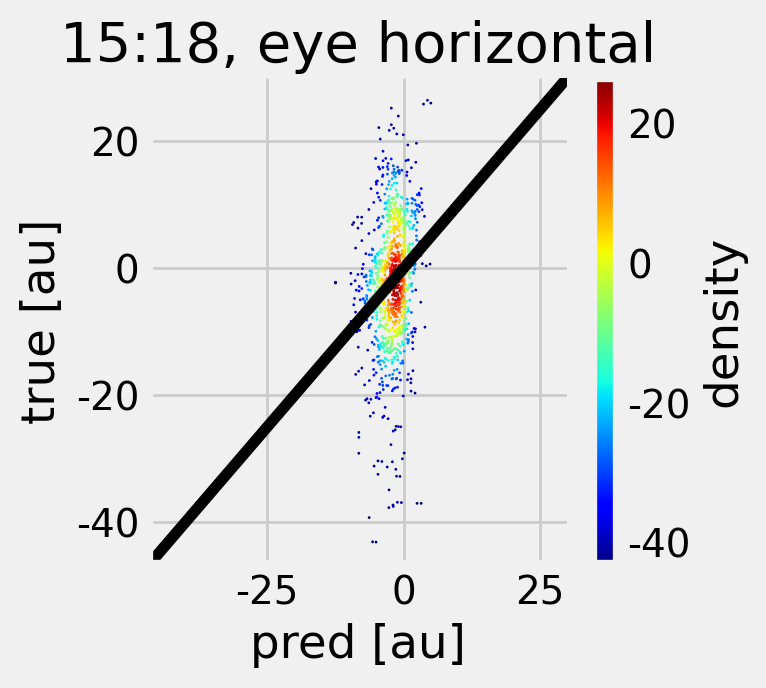

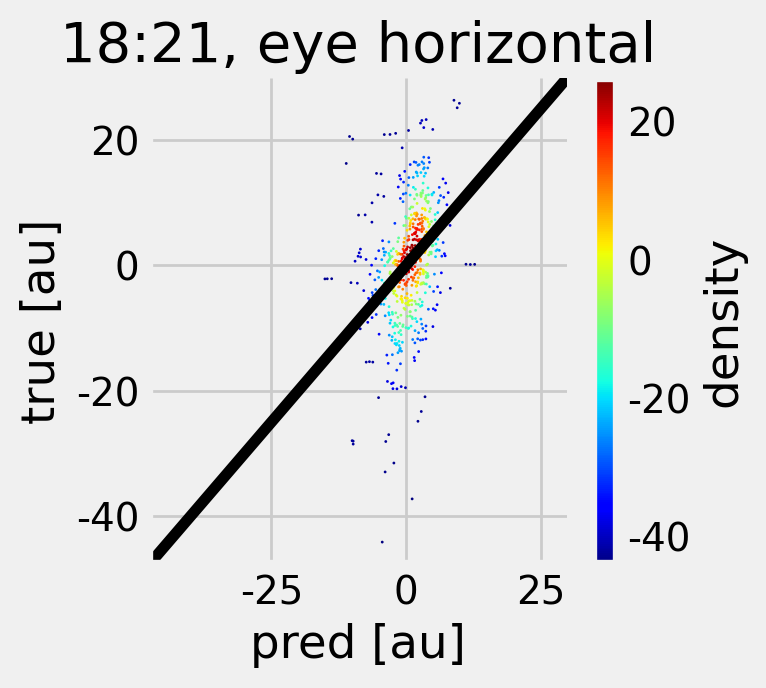

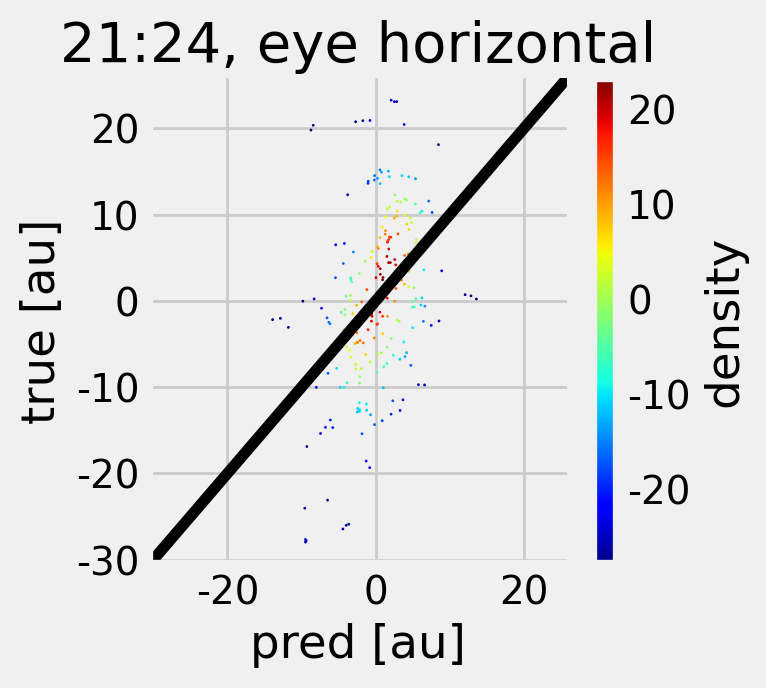

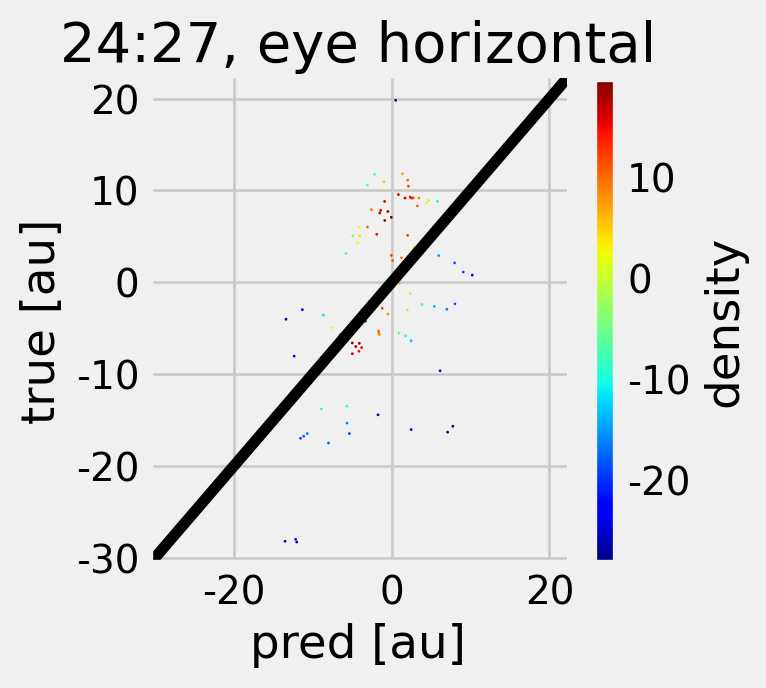

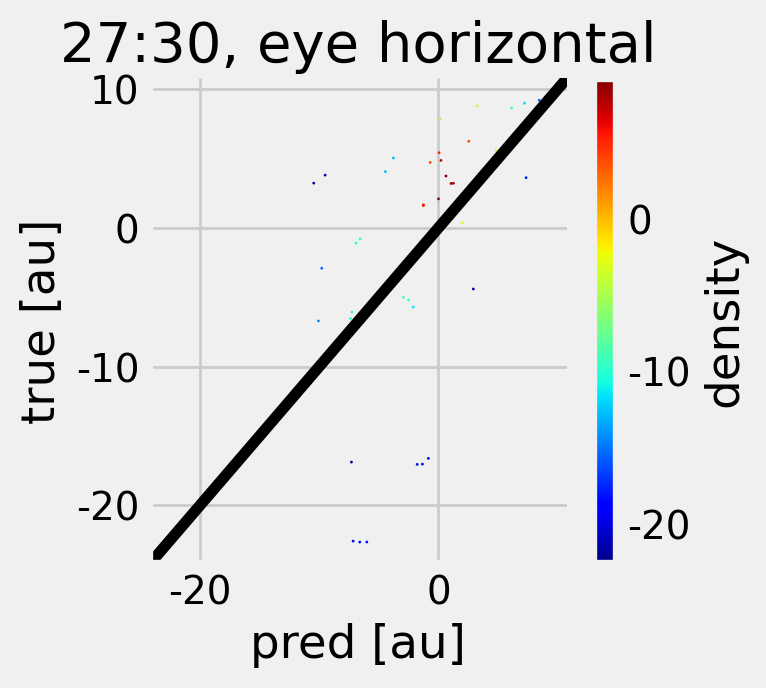

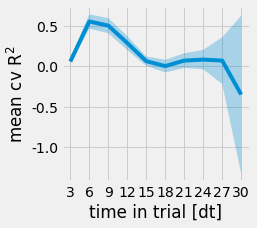

In [149]:
# bin the data by how long into the trial. 
binsize=3 # dt
bins=np.arange(0,(35//binsize)*binsize,binsize)

r2s=[]
r2serr=[]

for s,e in zip(bins[:-1],bins[1:]):
    thisbininds=[np.where(trial_idx==ith)[0][s:e] for ith in np.unique(trial_idx)]
    thisbininds=np.hstack(thisbininds)

    thisbinmodel=linear_model.Lasso(alpha=best_alpha)
    scores=cross_val_score(thisbinmodel,
        belief_rel[thisbininds], y[thisbininds,0], cv=5)
    r2s.append(np.mean(scores))
    r2serr.append(np.std(scores))

    thispred=cross_val_predict(
    thisbinmodel, belief_rel[thisbininds], y[thisbininds], cv=5)
    ax=plot_pred_scatter(thispred[:,0],y[thisbininds][:,0], title=f'{s}:{e}, eye horizontal', unit='au',every=1)
    plt.show()
    

plt.plot(bins[1:], r2s)
r2s=np.asarray(r2s)
r2serr=np.asarray(r2serr)
plt.fill_between(bins[1:], r2s-r2serr, r2s+r2serr, alpha=0.3)
plt.xlabel('time in trial [dt]')
plt.ylabel(r'mean cv $R^2$')
_=plt.gca().set_xticks(bins[1:])


In [157]:
# bin the data by how long into the trial. (no cv, just to debug)
binsize=3 # dt
bins=np.arange(0,(35//binsize)*binsize,binsize)

r2s=[]


for s,e in zip(bins[:-1],bins[1:]):
    thisbininds=[np.where(trial_idx==ith)[0][s:e] for ith in np.unique(trial_idx)]
    thisbininds=np.hstack(thisbininds)

    thisbinmodel=linear_model.Lasso(alpha=best_alpha)
    scores=model.score(belief_rel[thisbininds], y[thisbininds])
    r2s.append((scores))
    thisbinmodel.fit(belief_rel[thisbininds], y[thisbininds])
    thispred=thisbinmodel.predict(belief_rel[thisbininds])

    # ax=plot_pred_scatter(thispred[:,0],y[thisbininds][:,0], title=f'{s}:{e}, eye horizontal', unit='au',every=1)
    # plt.show()
    


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 2)

In [159]:
belief_rel[thisbininds].shape, y[thisbininds].shape

((2088, 2), (2088, 2))

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

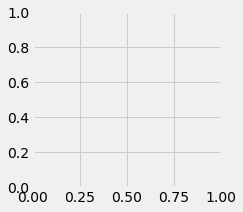

In [158]:

plt.plot(bins[1:], r2s)
r2s=np.asarray(r2s)
r2serr=np.asarray(r2serr)
# plt.fill_between(bins[1:], r2s-r2serr, r2s+r2serr, alpha=0.3)
plt.xlabel('time in trial [dt]')
plt.ylabel(r'mean cv $R^2$')
_=plt.gca().set_xticks(bins[1:])


### smooth pursuite vs fast saccades.

## on screen belief --> eye position angle

In [27]:
def world2screen(x_rel,y_rel,height=10,screen_dist=32.5 ):
    screen_z = height - screen_dist * height / y_rel
    screen_x = screen_dist * x_rel / y_rel

    screen_z[y_rel <= 0] = np.nan
    screen_x[y_rel <= 0] = np.nan

    return screen_x,screen_z

def world2mk(x_fly_rel, y_fly_rel):

    # phi = dt * np.cumsum(w)
    # R = lambda theta : np.array([[np.cos(theta/180*np.pi),-np.sin(theta/180*np.pi)],[np.sin(theta/180*np.pi),np.cos(theta/180*np.pi)]])
    XY = np.zeros((2,x_fly_rel.shape[0]))
    XY[0,:] = x_fly_rel
    XY[1,:] = y_fly_rel
    # rot = R(0)
    # XY = np.einsum('ijk,jk->ik', rot, XY)
    xfp_rel= XY[0, :]
    yfp_rel = XY[1, :]
    return xfp_rel,yfp_rel


belief_screen=np.stack(world2mk(belief_rel[:,0],belief_rel[:,1])).T

In [28]:
validmask=~np.isnan(belief_screen.sum(axis=1))
validmask

array([ True,  True,  True, ...,  True,  True,  True])

In [29]:

x = belief_screen[validmask]
y = np.vstack([eyeh, eyev]).T[validmask]

x.shape, y.shape

((11331, 2), (11331, 2))

In [30]:
# Create a parameter grid with alpha values
param_grid = {'alpha': [0.1, 1.0]}

# Initialize the Lasso model
model = linear_model.Lasso()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x, y)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

print("Best alpha value:", best_alpha)

Best alpha value: 1.0


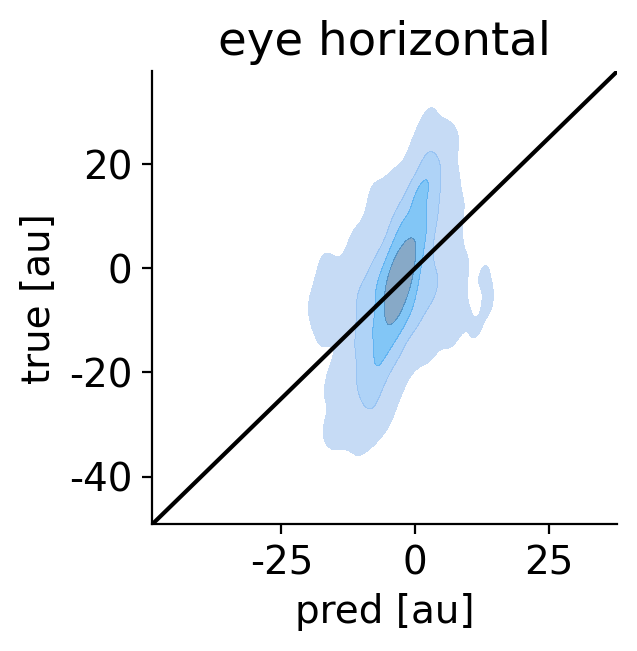

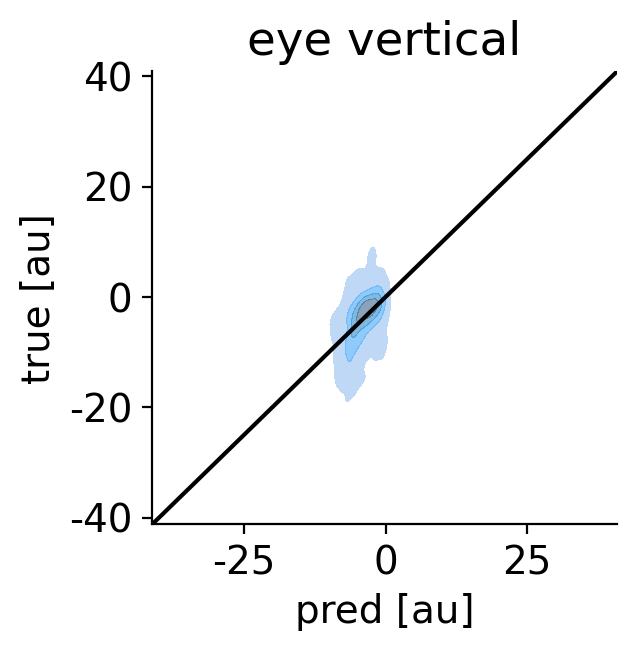

In [31]:
model = linear_model.Lasso(alpha=best_alpha)
model.fit(x,y)

pred=model.predict(x)

plot_pred(pred[:,0],y[:,0], title='eye horizontal', unit='au',every=1)
plot_pred(pred[:,1],y[:,1], title='eye vertical', unit='au',every=1)

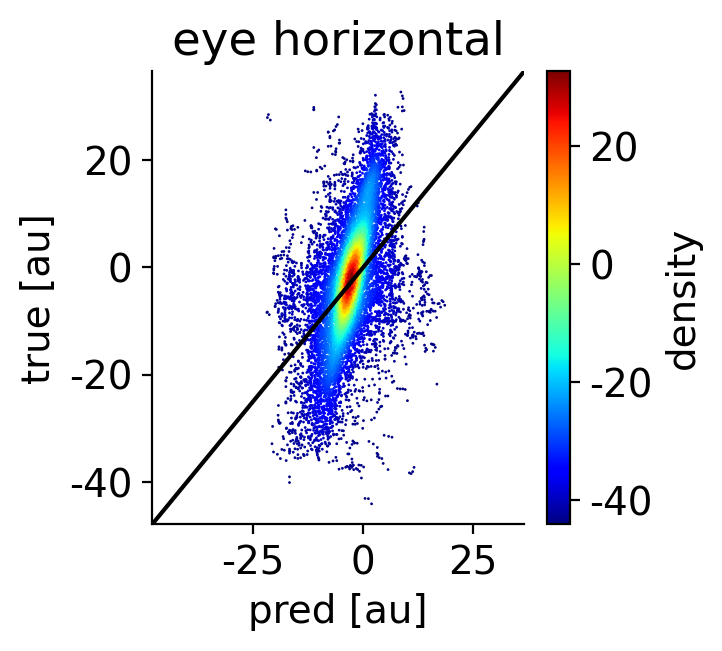

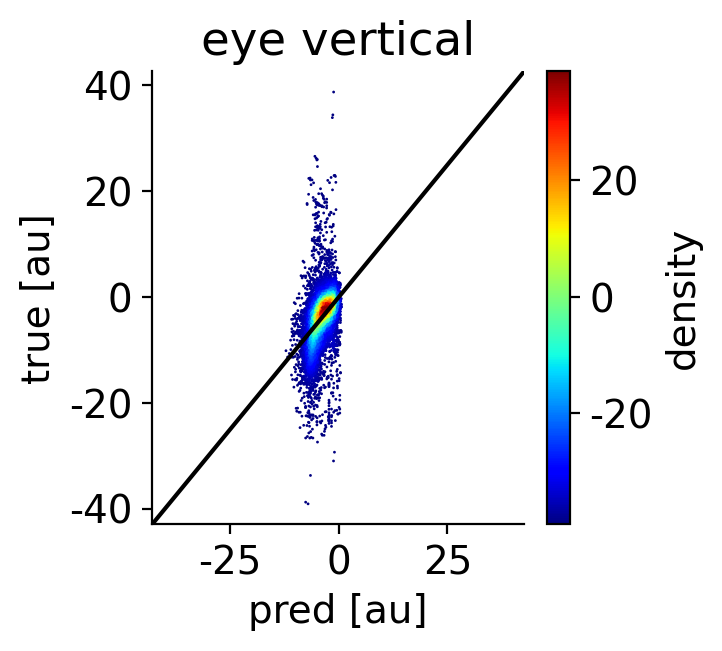

In [32]:

plot_pred_scatter(pred[:,0],y[:,0], title='eye horizontal', unit='au',every=1)
plot_pred_scatter(pred[:,1],y[:,1], title='eye vertical', unit='au',every=1)


obviously, there is strong correlation but there are something we cannot predict.
the mismatch in belief-->eye position seems like the random eye movement.

the change in position and change in eye position. we think most of the time they will correlated, but sometimes the eye will randommly saccade.

seperate the smooth pursue, and the saccade.

color code the dots, by relative time in the trial, or distance to target, mag of change.

3d, pred, true, change, 

### continue the fitting result, does the uncertainty matters to the eye position?